In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
import time


ModuleNotFoundError: No module named 'matplotlib'

In [2]:
import datetime
date = datetime.date.today()

In [3]:
# Downsampling using average pooling
"""
Downsample the input array to 35 elements using interpolation.
"""

def downsample_to_35(input_array):
    input_tensor = torch.tensor(input_array, dtype=torch.float32)
    
    # Reshape the input to be 1D (if it's not already)
    if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)  # Shape (1, 1, original_length)
    elif input_tensor.dim() == 2:
        input_tensor = input_tensor.unsqueeze(0)  # Shape (1, original_channels, original_length)
    
    # Perform interpolation to downsample to 35 elements
    downsampled_tensor = F.interpolate(input_tensor, size=35, mode='linear', align_corners=True)
    
    # Remove the unnecessary dimensions to return a 1D tensor
    downsampled_array = downsampled_tensor.squeeze().numpy()
    
    return downsampled_array

In [ ]:

def prep_data(root, keyword=None):

    # Initialization of arrays
    # Coordinates
    x_i = [] # Initial coordinates - before downsizing
    y_i = []

    # Polars
    alphas = []
    Cls = []
    Cds = []
    Cms = []

    if keyword:
        # lists of files in each dir
        coord_files = [f for f in os.listdir(root) if f == (keyword+'_coordinates.dat')]
        polar_files = [f for f in os.listdir(root) if f == ('xf-'+keyword+'-il-1000000.csv')]
    else:
        # lists of files in each dir
        coord_files = [f for f in os.listdir(root) if f.endswith('_coordinates.dat')]
        polar_files = [f for f in os.listdir(root) if f.endswith('.csv')]

    # Extract base names from coordinate files
    coord_bases = {re.sub(r'\_coordinates.dat$', '', f) for f in coord_files}
    polar_bases = {}
    for polar_file in polar_files:
        match = re.match(r'xf-(.*)-il-1000000\.csv$', polar_file)
        if match:
            base_name = match.group(1)
            polar_bases[base_name] = polar_file
    # print(polar_bases)
    for base_name in coord_bases:
        if base_name in polar_bases:
            coord_file = f"{base_name}_coordinates.dat"
            polar_file = polar_bases[base_name]

            coordinate_data = np.loadtxt(root+coord_file)
            # polar_data = np.loadtxt(root+polar_file, skiprows=12)
            polar_data = pd.read_csv(root+polar_file, skiprows=10)
            polar_data = polar_data[(polar_data['Alpha'] >= -2) & (polar_data['Alpha'] <= 10)]
            # print(len(polar_data))

            # Coordinates
            x = []
            y = []

            # Polars
            alpha = polar_data['Alpha'].values
            Cl = polar_data['Cl'].values
            Cd = polar_data['Cd'].values
            Cm = polar_data['Cm'].values

            # print(alpha)

            for i in range(0, len(coordinate_data)):
                np.array(x.append(float(coordinate_data[i][0]))) 
                np.array(y.append(float(coordinate_data[i][1])))
                
            if len(x) >= 35:    # Only consider the files with more than 35 coordinates
                x_i.append(x)
                y_i.append(y)

                alphas.append(alpha)

                for num_val in range(len(Cl)):
                    Cls.append(Cl[num_val])
                    Cds.append(Cd[num_val])
                    Cms.append(Cm[num_val])
                        
    return x_i, y_i, Cls, Cds, Cms, alphas
       

In [ ]:

root_train = "/mnt/e/eVTOL_model/eVTOL-AirfoilModel/data/training_database"
x_i, y_i, Cls, Cds, Cms, alphas = prep_data(root_train)
Cls = np.array(Cls, dtype=float)
Cds = np.array(Cds, dtype=float)


In [ ]:
# Downsample to 35 elements
x_f = [] # Final coordinates - after downsizing
y_f = []
for num_airfoil in range(0, len(x_i)):
    downsampled_x = downsample_to_35(x_i[num_airfoil])
    downsampled_y = downsample_to_35(y_i[num_airfoil])

    x_f.append(downsampled_x)
    y_f.append(downsampled_y)
    

853


## Arrange the data in the form of elements
* $E = [E_1, E_2, ....., E_n]$ 
* $E_1 = [x_1, y_1, x_2, y_2, \alpha]$

In [ ]:
# Arange the input data in columns [x, y, alpha, Re, M]

def organize_data(x_f, y_f, alphas):

    Elements = []

    # Loop through the polars
    for n_file in range(len(x_f)):
        x_temp = x_f[n_file]
        y_temp = y_f[n_file]
        alpha_temp = alphas[n_file]
        
        for j in range(len(alpha_temp)):
            batch = []
            # Loop through the coodrinates
            for i in range(len(x_temp)-1):
                element = np.array([x_temp[i], y_temp[i], x_temp[i+1], y_temp[i+1], alpha_temp[j]])
                # Elements.append(element)
                batch.append(element)
            batch = np.array(batch)
            batch = batch.flatten()
            Elements.append(batch)

    Elements = np.array(Elements)

    return Elements


In [8]:
Elements = organize_data(x_f, y_f, alphas)
print(Elements.shape)

(40622, 170)


## Neural Network Model

In [ ]:
# Element Spatial Convolutional Neural Network model

class ESCNN(nn.Module):
    def __init__(self):
        super(ESCNN, self).__init__()
        
        # Conv1: Assume 1D Convolution
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=200, kernel_size=5, stride=5)
        self.relu1 = nn.ReLU()

        #conv2
        self.conv2 = nn.Conv1d(in_channels=200, out_channels=200, kernel_size=1)
        self.relu2 = nn.ReLU()
        
        # Conv2
        self.conv3 = nn.Conv1d(in_channels=200, out_channels=1, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()
        
        # Final fully connected layer to output scalar
        self.fc1 = nn.Linear(in_features=34, out_features=34)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=34, out_features=1)

        # Define learnable parameters for C_d0 and k
        self.Cd0 = nn.Parameter(torch.tensor(0.02))  # Initialized zero-lift drag coefficient
        self.k = nn.Parameter(torch.tensor(0.05))    # Initialized induced drag factor

    
    def forward(self, x):
        # Reshape input if necessary, ensure it's in the shape (batch_size, channels, elements)
        x = x.view(-1, 1, 170)  # Reshape to (batch_size, channel=1, elements=170)
        
        x = self.conv1(x)  
        x = self.relu1(x)
        
        x = self.conv2(x)  
        x = self.relu2(x)

        x = self.conv3(x)  
        x = self.relu3(x)
        
        
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)  # (batch_size, 1)
        x = self.relu4(x)

        x = self.fc2(x)
        
        return x

model = ESCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


ESCNN(
  (conv1): Conv1d(1, 200, kernel_size=(5,), stride=(5,))
  (relu1): ReLU()
  (conv2): Conv1d(200, 200, kernel_size=(1,), stride=(1,))
  (relu2): ReLU()
  (conv3): Conv1d(200, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu3): ReLU()
  (fc1): Linear(in_features=34, out_features=34, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=34, out_features=1, bias=True)
)

Orgaize the data for the NN

In [ ]:
input_data = Elements
output_data = Cds
print(output_data.shape)


input_data_train, input_data_val, output_data_train, output_data_val = train_test_split(input_data, output_data, test_size=0.25, random_state=28)


(40622,)


In [ ]:
# Convert to PyTorch tensors
# And move the data to cuda

input_data_train = torch.from_numpy(input_data_train).float().to(device)
input_data_val = torch.from_numpy(input_data_val).float().to(device)

output_data_train = torch.from_numpy(output_data_train).float().to(device)
output_data_val = torch.from_numpy(output_data_val).float().to(device)

In [ ]:
# DataLoader
dataset_train = TensorDataset(input_data_train, output_data_train)
dataset_val = TensorDataset(input_data_val, output_data_val)

trainDataLoader = DataLoader(dataset_train, batch_size=128)
valDataLoader = DataLoader(dataset_val, batch_size=128)


## Train the Model

In [ ]:
def custom_loss(pred_cd, true_cd, cl_pred, model, criterion):
    # MSE loss between predicted and true Cd
    mse_loss = criterion(pred_cd, true_cd)
    
    # Physics-informed loss using the model's learnable Cd0 and k
    phy_cd = model.Cd0 + model.k * cl_pred ** 2
    drag_polar_loss = criterion(pred_cd, phy_cd)

    # Total loss
    total_loss = mse_loss + 0.2 * drag_polar_loss  # Adjust weight (0.1) as needed

    return total_loss


In [ ]:
# Load the Cl model
class ClModel(ESCNN):
    def __init__(self):
        super(ClModel, self).__init__()

# Initialize the model for Cl
cl_model = ClModel()
cl_model.load_state_dict(torch.load('/mnt/e/eVTOL_model/eVTOL-AirfoilModel/trained_model/Cl_models/2024-11-18_model_Cl_ESCNN_lr1e-05_e1500_rbf170_convL4.pth'), strict=False)
cl_model = cl_model.to(device)
cl_model.eval()


/tmp/ipykernel_185787/4011268001.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cl_model.load_state_dict(torch.load('model_Cl_lr1e5_e1500.pth'), strict=False)


ClModel(
  (conv1): Conv1d(1, 200, kernel_size=(5,), stride=(5,))
  (relu1): ReLU()
  (conv2): Conv1d(200, 200, kernel_size=(1,), stride=(1,))
  (relu2): ReLU()
  (conv3): Conv1d(200, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu3): ReLU()
  (fc1): Linear(in_features=34, out_features=34, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=34, out_features=1, bias=True)
)

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
lr = 5e-5
optimizer = optim.Adam(model.parameters(), lr=5e-5)
num_epochs = 250
num_convL_layer = 3

# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"val_loss": [],
    "Cd0_train": [],
    "Cd0_val": [],
    "k_train": [],
    "k_val": []

}

# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()


# Training loop

for e in range(0, num_epochs):
    model.train()

    totalTrainLoss = 0
    totalValLoss = 0

    for (ip, op) in trainDataLoader:
        pred_cd = model(ip)
        pred_cd = pred_cd.squeeze(1)

        with torch.no_grad():  # Cl model is pre-trained and frozen
            cl_pred = cl_model.forward(ip)
            cl_pred = cl_pred.squeeze(1)

        # Compute the custom loss (data + physics-informed loss)
        loss = custom_loss(pred_cd, op, cl_pred, model, criterion)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalTrainLoss += loss.item()

     # Store the values of Cd0 and k after each epoch
    H["Cd0_train"].append(model.Cd0.item())
    H["k_train"].append(model.k.item())

    with torch.no_grad():
        model.eval()

        for (ip, op) in valDataLoader:
            pred_cd = model(ip)
            pred_cd = pred_cd.squeeze(1)

            cl_pred = cl_model.forward(ip)
            cl_pred = cl_pred.squeeze(1)

            val_loss = custom_loss(pred_cd, op, cl_pred, model, criterion)
            totalValLoss += val_loss.item()

         # Store the values of Cd0 and k after each epoch
        H["Cd0_val"].append(model.Cd0.item())
        H["k_val"].append(model.k.item())

    avgTrainLoss = totalTrainLoss / len(trainDataLoader.dataset)
    avgValLoss = totalValLoss / len(valDataLoader.dataset)

    H["train_loss"].append(avgTrainLoss)
    H["val_loss"].append(avgValLoss)

    print(f"Epoch: {e+1}/{num_epochs}, Train Loss: {avgTrainLoss:.8f}, Val Loss: {avgValLoss:.8f}")

print("Finished Training")


[INFO] training the network...
Epoch: 1/250, Train Loss: 0.00000045, Val Loss: 0.00000027
Epoch: 2/250, Train Loss: 0.00000022, Val Loss: 0.00000020
Epoch: 3/250, Train Loss: 0.00000019, Val Loss: 0.00000019
Epoch: 4/250, Train Loss: 0.00000019, Val Loss: 0.00000019
Epoch: 5/250, Train Loss: 0.00000018, Val Loss: 0.00000018
Epoch: 6/250, Train Loss: 0.00000018, Val Loss: 0.00000017
Epoch: 7/250, Train Loss: 0.00000018, Val Loss: 0.00000017
Epoch: 8/250, Train Loss: 0.00000017, Val Loss: 0.00000017
Epoch: 9/250, Train Loss: 0.00000017, Val Loss: 0.00000017
Epoch: 10/250, Train Loss: 0.00000017, Val Loss: 0.00000017
Epoch: 11/250, Train Loss: 0.00000017, Val Loss: 0.00000016
Epoch: 12/250, Train Loss: 0.00000017, Val Loss: 0.00000016
Epoch: 13/250, Train Loss: 0.00000017, Val Loss: 0.00000016
Epoch: 14/250, Train Loss: 0.00000016, Val Loss: 0.00000015
Epoch: 15/250, Train Loss: 0.00000016, Val Loss: 0.00000016
Epoch: 16/250, Train Loss: 0.00000016, Val Loss: 0.00000016
Epoch: 17/250, Tra

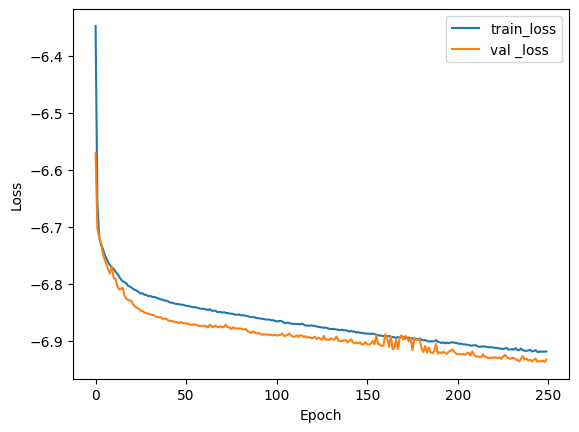

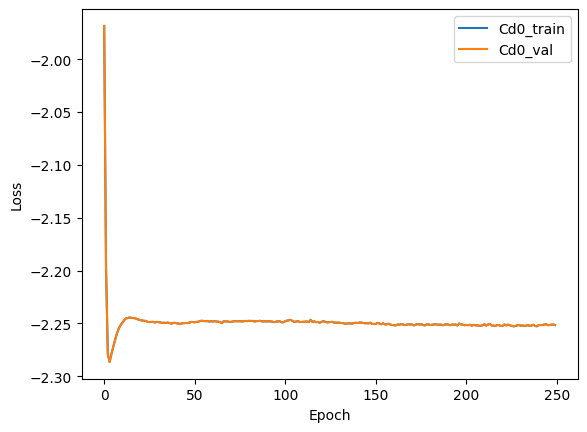

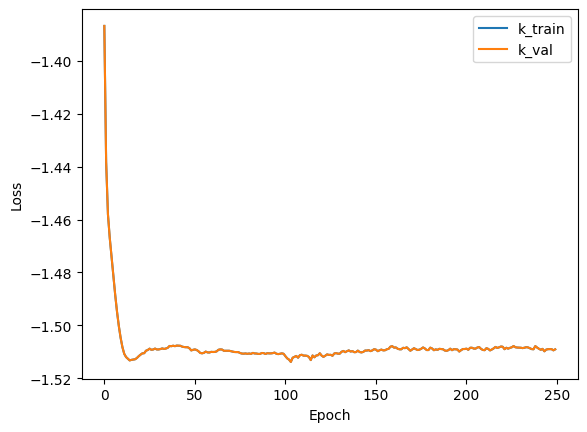

In [ ]:
# Plot the results

plt.figure()
plt.plot(np.log10(H["train_loss"]), label="train_loss")
plt.plot(np.log10(H["val_loss"]), label="val _loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.figure()
plt.plot(np.log10(H["Cd0_train"]), label="Cd0_train")
plt.plot(np.log10(H["Cd0_val"]), label="Cd0_val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.figure()
plt.plot(np.log10(H["k_train"]), label="k_train")
plt.plot(np.log10(H["k_val"]), label="k_val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()





In [19]:
# Save the model if needed
save_path = './trained_model_cd/{}_model_Cd_ESCNN_lr{}_e{}_convL{}.pth'.format(date, lr, num_epochs,num_convL_layer)

torch.save(model.state_dict(), save_path)

## Evaluate the model

Elements:  (49, 170)
Cds:  (49,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (29, 170)
Cds:  (29,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (0,)
Cds:  (0,)
Elements:  (0,)
Cds:  (0,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (46, 170)
Cds:  (46,)
Elements:  (38, 170)
Cds:  (38,)
Elements:  (0,)
Cds:  (0,)
Elements:  (0,)
Cds:  (0,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (47, 170)
Cds:  (47,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (46, 170)
Cds:  (46,)
Elements:  (0,)
Cds:  (0,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (0,)
Cds:  (0,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (0,)
Cds:  (0,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (48, 170)
Cds:  (48,)


/tmp/ipykernel_185787/339032383.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Elements:  (47, 170)
Cds:  (47,)
Elements:  (23, 170)
Cds:  (23,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (0,)
Cds:  (0,)
Elements:  (0,)
Cds:  (0,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (46, 170)
Cds:  (46,)
Elements:  (0,)
Cds:  (0,)
Elements:  (47, 170)
Cds:  (47,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (0,)
Cds:  (0,)
Elements:  (47, 170)
Cds:  (47,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (47, 170)
Cds:  (47,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (0,)
Cds:  (0,)
Elements:  (24, 170)
Cds:  (24,)
Elements:  (47, 170)
Cds:  (47,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (47, 170)
Cds:  (47,)
Elements:  (46, 170)
Cds:  (46,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (48, 170)
Cds:  (48,)
Element

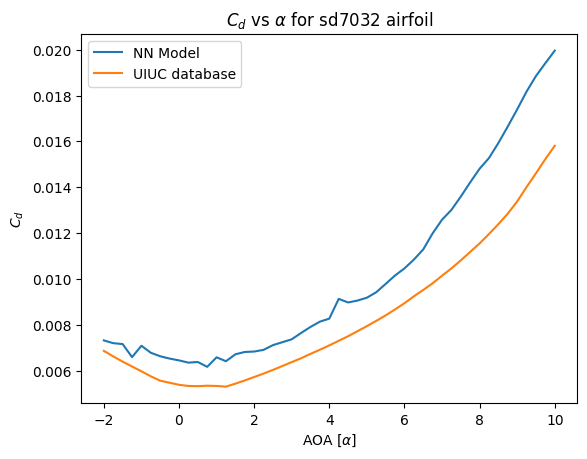

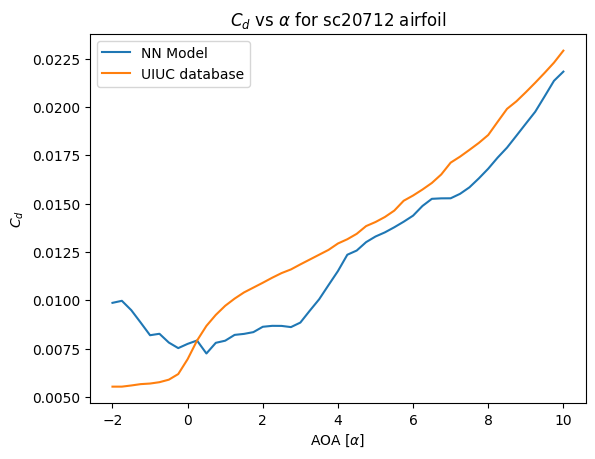

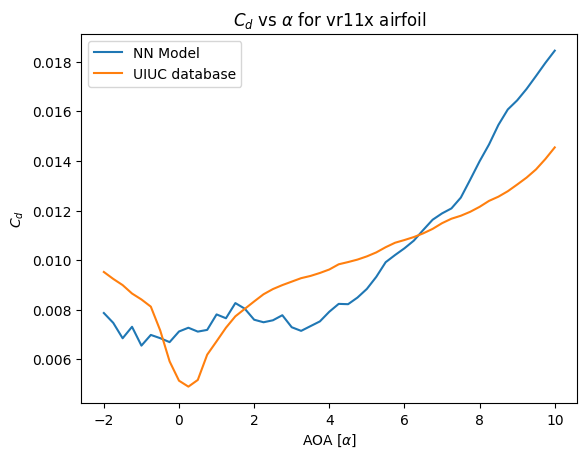

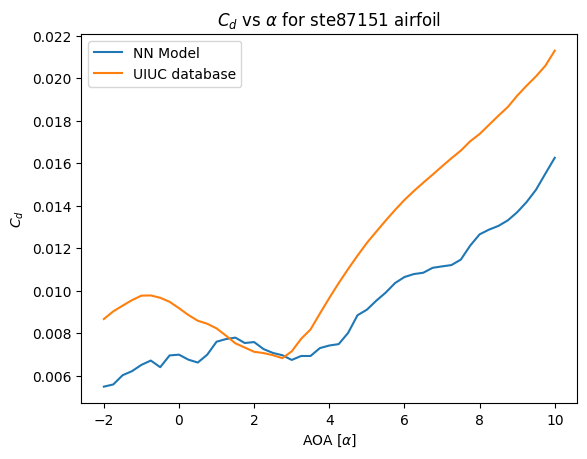

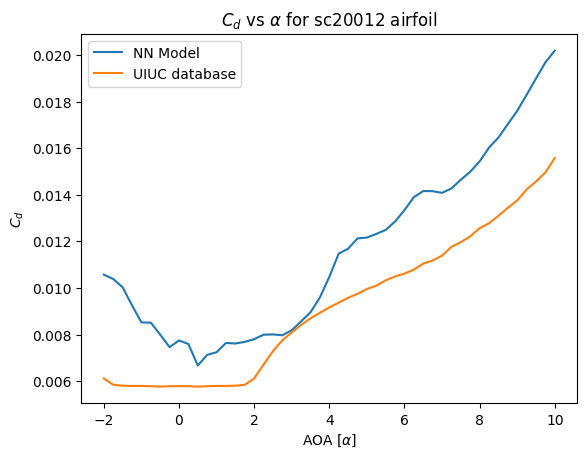

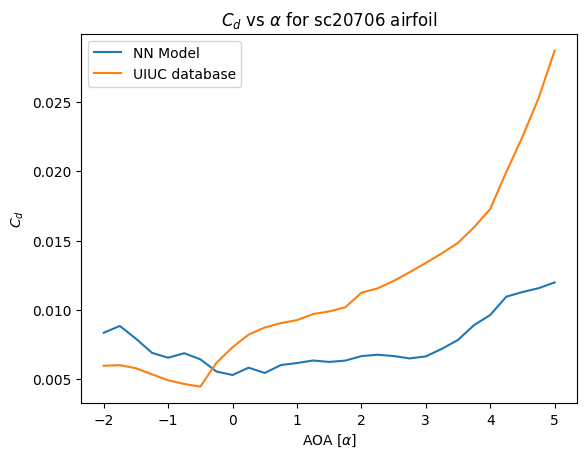

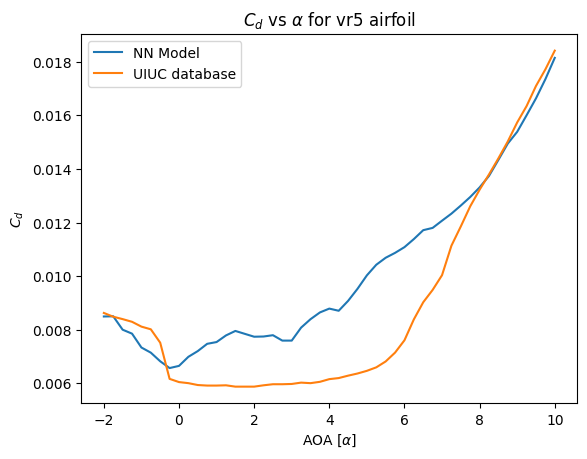

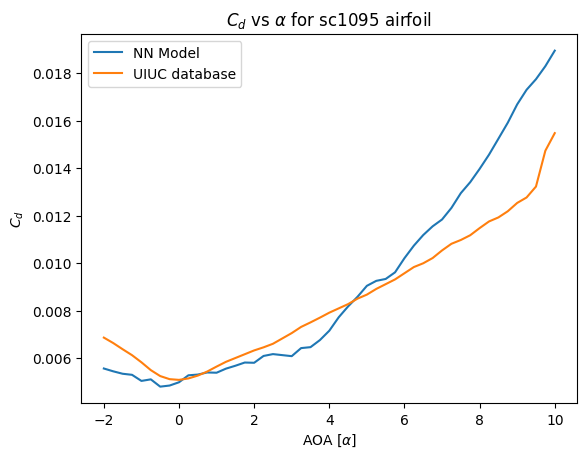

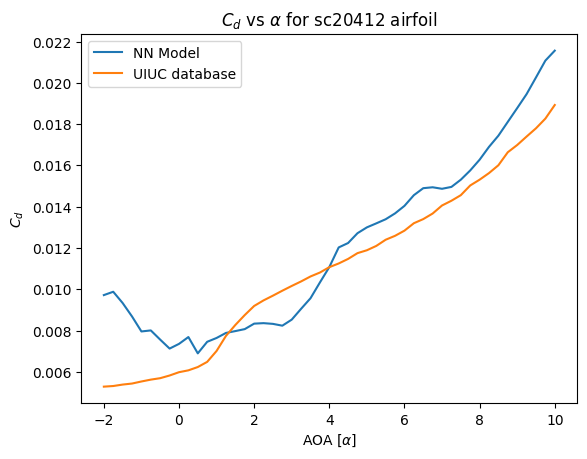

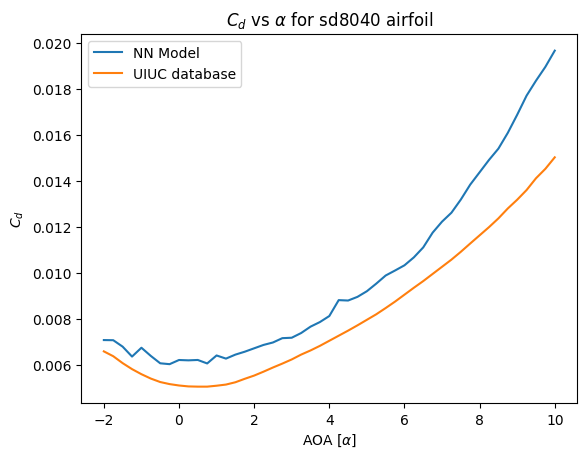

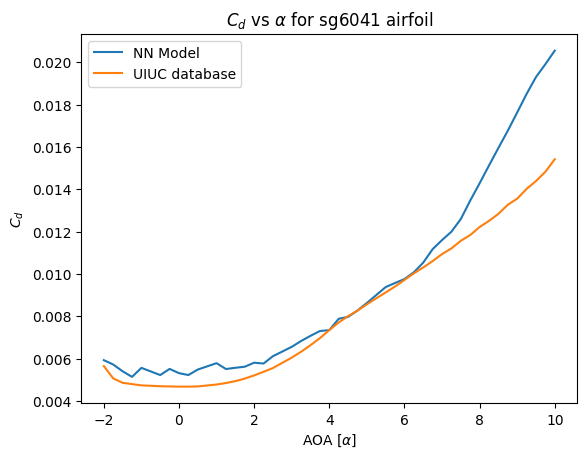

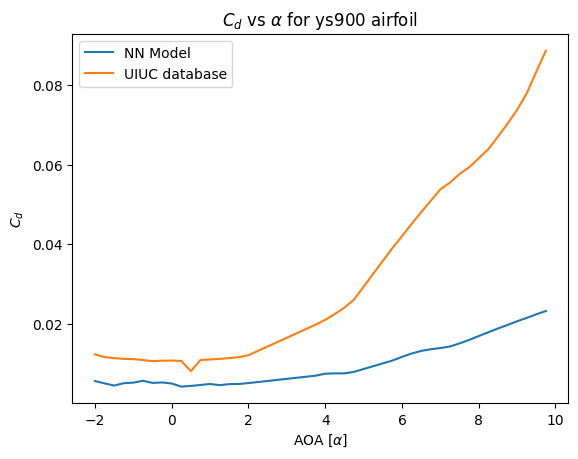

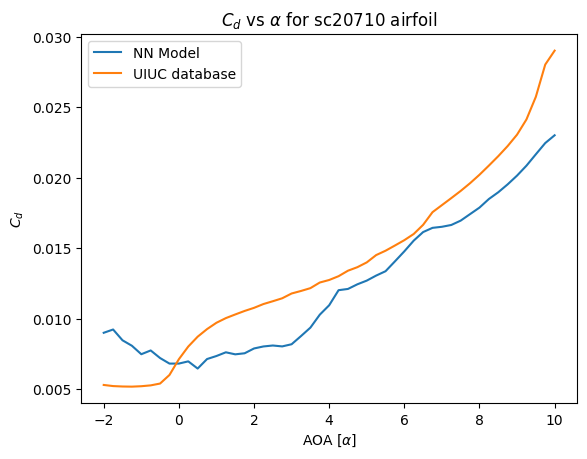

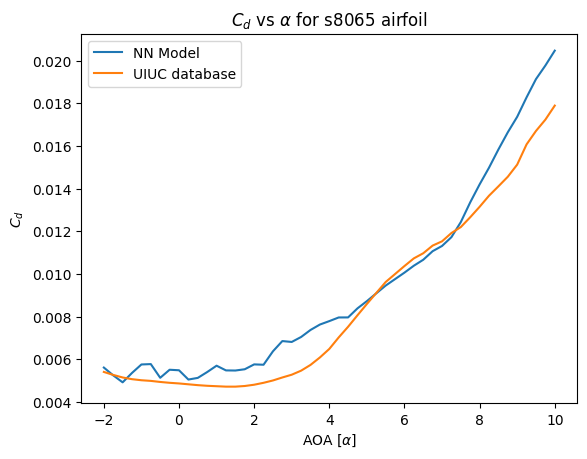

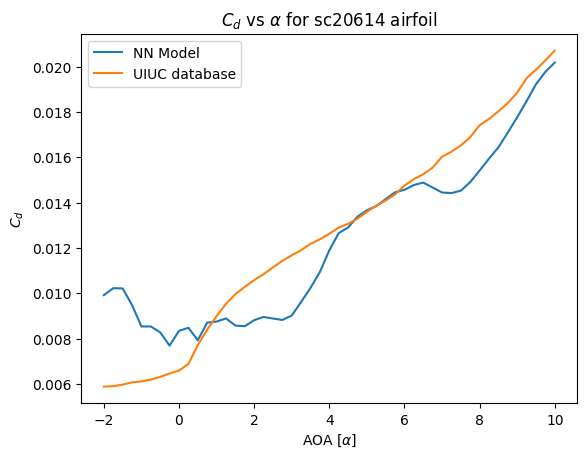

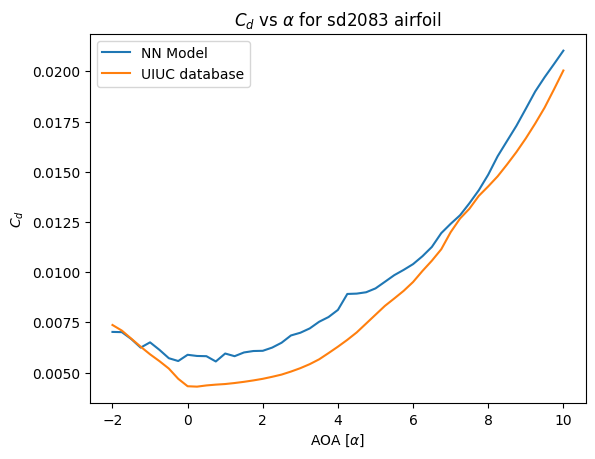

In [ ]:
root_test = "database_testing_csv/"

coord_files = [f for f in os.listdir(root_test) if f.endswith('_coordinates.dat')]
coord_bases = {re.sub(r'\_coordinates.dat$', '', f) for f in coord_files}

for keyword in coord_bases:
    x_t, y_t, Cls_t, Cds_t, Cms_t, alphas_t = prep_data(root_test, keyword)
    Cls_t = np.array(Cls_t, dtype=float)
    Cds_t = np.array(Cds_t, dtype=float)
    Cms_t = np.array(Cms_t, dtype=float)
    
    x_f_t = [] # Final coordinates - after downsizing
    y_f_t = []
    for num_airfoil in range(0, len(x_t)):
        downsampled_x = downsample_to_35(x_t[num_airfoil])
        downsampled_y = downsample_to_35(y_t[num_airfoil])

        x_f_t.append(downsampled_x)
        y_f_t.append(downsampled_y)
        
    Elements_t = organize_data(x_f_t, y_f_t, alphas_t)
    print("Elements: ",Elements_t.shape)
    print("Cds: ",Cds_t.shape)

    if Elements_t.shape != (0,):
        input_data_test = Elements_t

        # Convert to PyTorch tensors
        input_data_test = torch.tensor(input_data_test, dtype=torch.float32)

        # Move data to GPU
        input_data_test = input_data_test.to(device)

        # Evaluate the model on test dataset
        with torch.no_grad():
            Cd_eval = model.forward(input_data_test)
            # loss = criterion(Cl_eval, Cls_test[0])

        plt.figure()
        plt.plot(alphas_t[0], Cd_eval.cpu().numpy())
        plt.plot(alphas_t[0],Cds_t)

        plt.legend(['NN Model', 'UIUC database'])
        plt.title(r'$C_d$ vs $\alpha$ for {} airfoil'.format(keyword))
        plt.xlabel(r'AOA [$\alpha$]')
        plt.ylabel(r'$C_d$')

    else:
        continue

